In [194]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [195]:
# =========== Load & Preprocess Data ===========
data_path = "../feature_engineering/processed_swim_features.csv"
df = pd.read_csv(data_path)

# Filter only pre-18 data
df_pre18 = df[df["Age_at_time_of_Swim"] < 18].copy()

# Remove non-standard, rarely swum events
events_to_remove = ["50 BR SCY", "50 BK SCY", "50 FL SCY", "100 IM SCY", "400 FR LCM"]
df_pre18 = df_pre18[~df_pre18["Event"].isin(events_to_remove)]

print(f"Total unique events after removal: {df_pre18['Event'].nunique()}")

Total unique events after removal: 14


In [196]:
# Define weight mapping for different age ranges
def age_weight(age):
    if age >= 14:
        return 1.5  # Highest weight for most relevant performances
    elif age >= 10:
        return 1.2  # Medium weight for early competitive years
    else:
        return 1.0  # Lowest weight for very early years


In [197]:
# =========== Feature Engineering: Aggregate Per Swimmer ===========
swimmer_data = []
standard_events = df_pre18["Event"].unique()

for name, swimmer_df in df_pre18.groupby("Name"):
    specialty_1 = swimmer_df["Specialty_1"].iloc[0]
    specialty_2 = swimmer_df["Specialty_2"].iloc[0]
    career_length = swimmer_df["Career_Length"].iloc[0]

    swimmer_record = {
        "Name": name,
        "Career_Length": career_length,
        "Total_Swims": len(swimmer_df),
        "Num_Unique_Events": swimmer_df["Event"].nunique(),
        "Specialty_1": specialty_1,
        "Specialty_2": specialty_2
    }

    # Add event-specific features
    for event in standard_events:
        event_data = swimmer_df[swimmer_df["Event"] == event]

        if not event_data.empty:
            swimmer_record[f"Best_Spec_{event}"] = event_data["Specialization_Score"].max()
        else:
            swimmer_record[f"Best_Spec_{event}"] = 0

    swimmer_data.append(swimmer_record)

# Convert to DataFrame
swimmers_df = pd.DataFrame(swimmer_data)

# Handle missing values
swimmers_df.replace([np.inf, -np.inf], np.nan, inplace=True)
swimmers_df.fillna(0, inplace=True)

print(f"Updated dataset shape: {swimmers_df.shape}")


Updated dataset shape: (94, 20)


In [198]:
# =========== Regression Target Preparation ===========
# Remove swimmers with removed specialties
events_to_remove = ["800 Free", "400 Free"]

# Remove swimmers who had these events as their primary or secondary specialty
swimmers_df = swimmers_df[~swimmers_df["Specialty_1"].isin(events_to_remove)]
swimmers_df = swimmers_df[~swimmers_df["Specialty_2"].isin(events_to_remove)]

# Ensure no NaN values exist by filling with a placeholder
swimmers_df["Specialty_1"] = swimmers_df["Specialty_1"].fillna("Unknown")
swimmers_df["Specialty_2"] = swimmers_df["Specialty_2"].fillna("Unknown")



In [199]:
# =========== Prepare Target Variables ===========
label_encoder = LabelEncoder()

# Fit LabelEncoder on both Specialty_1 and Specialty_2
all_specialties = pd.concat([swimmers_df["Specialty_1"], swimmers_df["Specialty_2"]]).unique()
label_encoder.fit(all_specialties)

# Transform both Specialty columns
swimmers_df["Specialty_1_Label"] = label_encoder.transform(swimmers_df["Specialty_1"])
swimmers_df["Specialty_2_Label"] = label_encoder.transform(swimmers_df["Specialty_2"])

# Define classification targets
target_cols = ["Specialty_1_Label", "Specialty_2_Label"]


In [200]:
# =========== Feature Selection & Scaling ===========
feature_cols = [col for col in swimmers_df.columns if col.startswith("Best_Spec_")]

X = swimmers_df[feature_cols]  # Features: Specialization scores across all events
y = swimmers_df[target_cols]  # Targets: Specialty labels

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize multi-output classification model
clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42))



In [201]:
# =========== Train Model & Perform Cross-Validation ===========
clf.fit(X_scaled, y)

# Perform cross-validation predictions
y_pred_cv = cross_val_predict(clf, X_scaled, y, cv=kf)

# Convert predictions to DataFrame
y_pred_df = pd.DataFrame(y_pred_cv, columns=["Predicted_Specialty_1_Label", "Predicted_Specialty_2_Label"])
y_true_df = pd.DataFrame(y, columns=["Specialty_1_Label", "Specialty_2_Label"])

# Compute accuracy for each specialty separately
accuracy_specialty_1 = accuracy_score(y_true_df["Specialty_1_Label"], y_pred_df["Predicted_Specialty_1_Label"])
accuracy_specialty_2 = accuracy_score(y_true_df["Specialty_2_Label"], y_pred_df["Predicted_Specialty_2_Label"])

# Compute F1-score for each specialty
f1_specialty_1 = f1_score(y_true_df["Specialty_1_Label"], y_pred_df["Predicted_Specialty_1_Label"], average="weighted")
f1_specialty_2 = f1_score(y_true_df["Specialty_2_Label"], y_pred_df["Predicted_Specialty_2_Label"], average="weighted")

# Print the results
print(f"Accuracy for Specialty 1: {accuracy_specialty_1:.4f}")
print(f"Accuracy for Specialty 2: {accuracy_specialty_2:.4f}")
print(f"F1-Score for Specialty 1: {f1_specialty_1:.4f}")
print(f"F1-Score for Specialty 2: {f1_specialty_2:.4f}")

Accuracy for Specialty 1: 0.4457
Accuracy for Specialty 2: 0.2500
F1-Score for Specialty 1: 0.3972
F1-Score for Specialty 2: 0.2271


In [202]:
# =========== Predict Specialties ===========

# Use the cross-validation predictions:
y_pred_df = pd.DataFrame(y_pred_cv, columns=["Predicted_Specialty_1_Label", "Predicted_Specialty_2_Label"])

# Convert numerical predictions back to event names
predicted_specialty_1 = label_encoder.inverse_transform(y_pred_df["Predicted_Specialty_1_Label"])
predicted_specialty_2 = label_encoder.inverse_transform(y_pred_df["Predicted_Specialty_2_Label"])

# Create comparison DataFrame with the cross-validation predictions
comparison_df = swimmers_df[["Name", "Specialty_1", "Specialty_2"]].copy()
comparison_df["Predicted_Specialty_1"] = predicted_specialty_1
comparison_df["Predicted_Specialty_2"] = predicted_specialty_2
# Display first few rows
print(comparison_df.head())

# Optionally, save results to a CSV file for review
comparison_df.to_csv("predictions_vs_actual_specialties.csv", index=False)


            Name Specialty_1 Specialty_2 Predicted_Specialty_1  \
0     Abby Arens  100 Breast     100 Fly                200 IM   
1    Abby Daniel     100 Fly      200 IM            100 Breast   
2  Abby McCulloh   1650 Free   1000 Free             1650 Free   
3  Alex Shackell     200 Fly     200 Fly              100 Back   
4     Alex Walsh      200 IM  200 Breast                200 IM   

  Predicted_Specialty_2  
0                400 IM  
1            200 Breast  
2              500 Free  
3              200 Back  
4              100 Free  


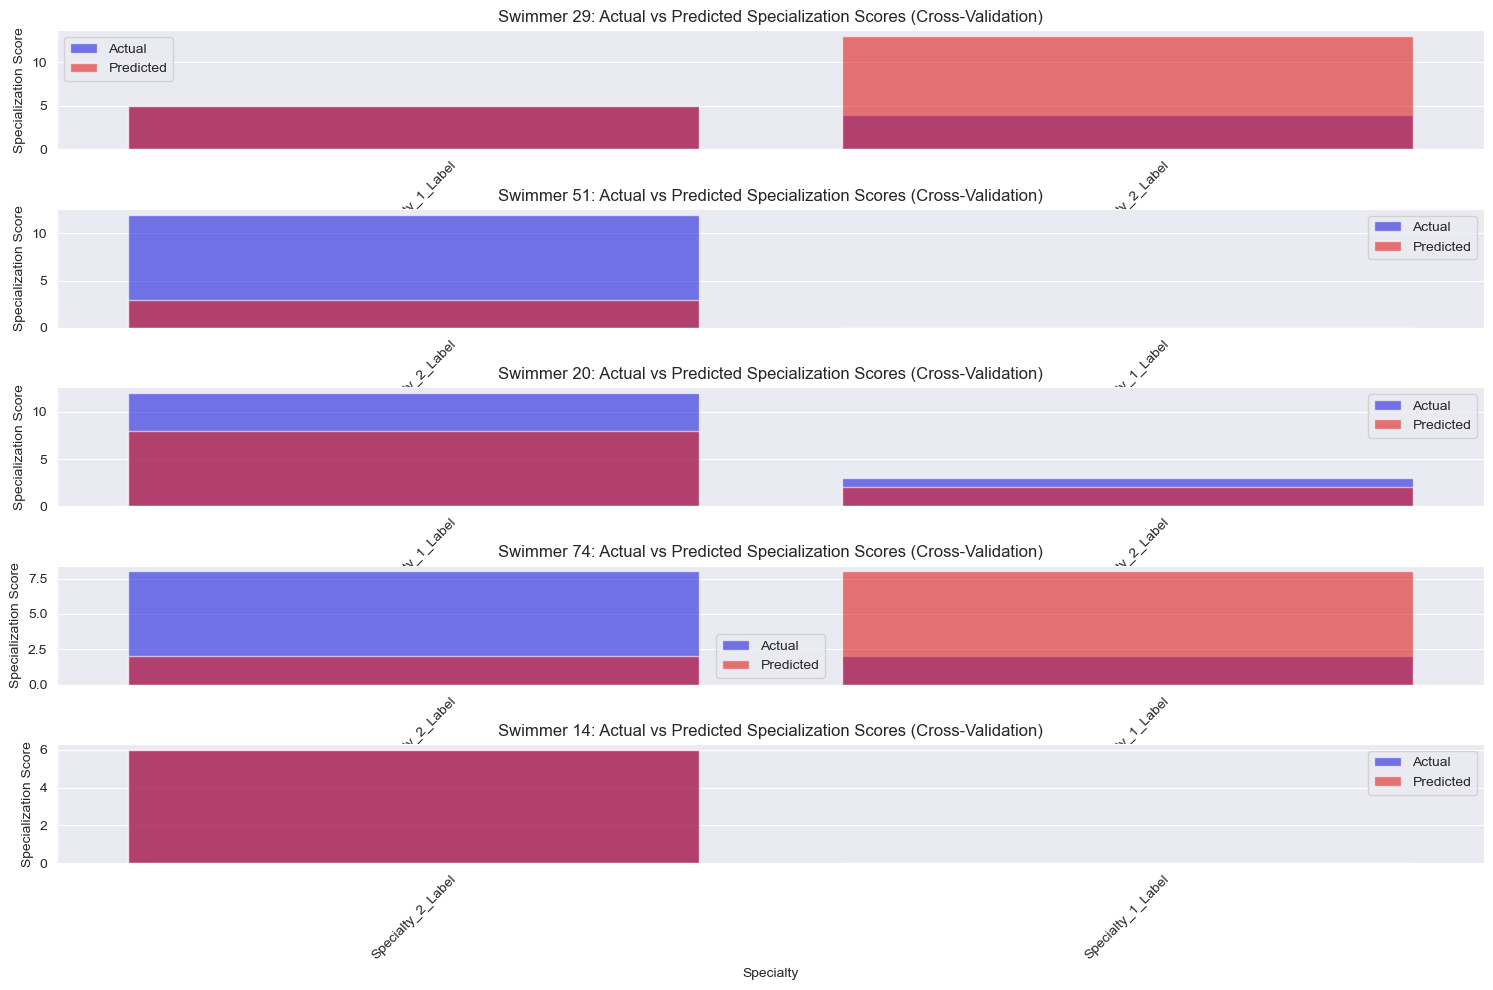

In [203]:
# =========== Predicted Specialization Scores Visualization ===========
# Select a few random swimmers for visualization
sample_size = min(5, len(y_true_df))  # Use cross-validation true values
sample_indices = np.random.choice(len(y_true_df), sample_size, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    plt.subplot(sample_size, 1, i+1)
    
    # Get actual and predicted scores from cross-validation results
    actual = y_true_df.iloc[idx].values
    predicted = y_pred_df.iloc[idx].values
    
    # Create DataFrame for plotting
    plot_data = pd.DataFrame({
        'Specialty': [col.replace('SpecScore_', '') for col in target_cols],
        'Actual': actual,
        'Predicted': predicted
    })
    
    # Sort by actual score for better visualization
    plot_data = plot_data.sort_values('Actual', ascending=False)
    
    # Plot
    sns.barplot(x='Specialty', y='Actual', data=plot_data, color='blue', alpha=0.6, label='Actual')
    sns.barplot(x='Specialty', y='Predicted', data=plot_data, color='red', alpha=0.6, label='Predicted')
    
    plt.title(f"Swimmer {idx}: Actual vs Predicted Specialization Scores (Cross-Validation)")
    plt.xlabel("Specialty")
    plt.ylabel("Specialization Score")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()